# Place Cell Detection

After we have extracted the neurons from the movie and got the calcium data, we can start with the data analysis.

The first (automated) step is to find place cells. There are several ways of determining whether a cell is a place cell. Some people use mutual information as a measure of spatial information content of a cell's activity and accept place cells if the SI has a p-value of 5%. This method is mainly used in e-phys data.

Here, we use a bit more complex criteria used by people on calcium data, which might be a bit more suitable (see ``Dombeck et al. 2010``; ``Hainmüller & Bartos 2018``)

In [1]:
# Import packages
import sys
sys.path.append('../custom scripts/')

import pickle
import numpy as np
import matplotlib.pyplot as plt
import place_cell_class as pc
import place_cell_pipeline as pipe


### Load data in the CNM object and set Place Cell Finder parameters

In [2]:
# Set directory of the session
root = r'W:\Neurophysiology-Storage1\Wahl\Hendrik\PhD\Data\Batch2\M19\20191204\N2'

# Set parameters
pcf_params = {'root': root,     # main directory of this session
          'trans_length': 0.5,  # minimum length in seconds of a significant transient
          'trans_thresh': 4,    # factor of sigma above which a transient is significant
          'bin_length': 5,      # length in cm VR distance in which to bin dF/F trace (must be divisor of track_length)
          'bin_window_avg': 3,  # sliding window of bins (left and right) for trace smoothing
          'bin_base': 0.25,     # fraction of lowest bins that are averaged for baseline calculation
          'place_thresh': 0.25, # threshold of being considered for place fields, calculated
                                #     from difference between max and baseline dF/F
          'min_pf_size': 15,    # minimum size in cm for a place field (should be 15-20 cm)
          'fluo_infield': 7,    # factor above which the mean DF/F in the place field should lie vs. outside the field
          'trans_time': 0.2,    # fraction of the (unbinned!) signal while the mouse is located in
                                # the place field that should consist of significant transients
          'track_length': 400,  # length in cm of the virtual reality corridor
          'split_size': 50}     # size in frames of bootstrapping segments

# Load CNM object
cnm = pipe.load_cnmf(root)

Loading file W:\Neurophysiology-Storage1\Wahl\Hendrik\PhD\Data\Batch2\M19\20191204\N2\cnm_results_manual.hdf5...


C:\Anaconda3\envs\caiman\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


## Place cell finding pipeline

### Initialize PCF object and split session trace into trials

The first step is to initialize the PCF object which will hold all the data (including the raw data of the CNM object).

The calcium data is for now stored in one long array containing all frames of the session, because CaImAn analyses all trials of one session together. We thus have to first split this long array into multiple arrays, one for each trial. Trial lenghts are gathered from the frame count of the movie .tif files.

In [3]:
# Initialize PCF object with the raw data (CNM object) and the parameter dict
pcf = pc.PlaceCellFinder(cnm, pcf_params)

# split traces into trials'
pcf.split_traces_into_trials()


Successfully separated traces into trials and sorted them by neurons.
Results are stored in pcf.session.



### Import behavior, align traces, find significant transients

We want to associate the calcium activity with the behavior, i.e. the mouse's position in the VR. We thus have to import the behavior files and align the traces to the VR position. 

For this, the calcium activity for each trial is averaged over position bins. This means that for every X cm of VR region there is one fluorescence value for each neuron. This brings trials with different lengths into one comparable frame. 

Additionally, it is advised that frames which were recorded while the mouse was not running are removed. Place cells loose specificity when the mouse is not moving through the environment, so removing resting frames improves place cell performance.

Another step is to find significant transients only and create traces where everything except these transients are set to 0.  Significant transients are chosen on the criteria of ``Koay et al. (2019)``. All continuous activity period above 4x noise level are considered transients. Noise level is calculated via FWHM, which is a bit less vulnerable to outliers (very high activity spikes) than "normal" standard deviation. The significant-transient-only traces are needed for the place cell detection later.

In [4]:
# Import behavior and align traces to it, while removing resting frames
pcf.import_behavior_and_align_traces()
pcf.params['resting_removed'] = True
pcf.bin_activity_to_vr(remove_resting=pcf.params['resting_removed'])

# create significant-transient-only traces
%matplotlib inline
# pcf.params['trans_thresh'] = (2, 0.5)
pcf.create_transient_only_traces()


Successfully aligned calcium data to the VR position bins.
Results are stored in pcf.bin_activity and pcf.bin_avg_activity.


Successfully created transient-only traces.
They are stored in pcf.session_trans.


### Find place cells

Now everything is set to look for place cells in our data. We do the analysis on dF/F data that is binned to the VR position and averaged over trials. This is being done in several steps:

 - Screen data for potential place fields: Bins where dF/F is higher than 25% of the difference between the baseline and maximum dF/F are considered potential place fields. The baseline activity is taken as the mean of the 25% least active bins.
 - On these potential place fields, apply three place field criteria:
     1. Place field is at least 15 cm (3 bins) wide.
     2. The average dF/F of the field is at least 7x higher than the mean dF/F outside the field.
     3. The raw, unbinned dF/F trace of this neuron consists of significant transients for at least 20% of the time the mouse spends in the field.
 - If a field passes all three criteria, perform bootstrapping: 
     - Shuffle the unbinned dF/F trace of each trial 1000x in 50-frame bits
     - Apply place field criteria on every shuffled trace
     - If <5% of shuffled traces pass all criteria, the place field is accepted
     
This is all being done by the main function ``find_place_cells()``.

Neuron 57 identified as place cell with p=0.045!
Neuron 99 identified as place cell, but p=0.495.
Neuron 162 identified as place cell, but p=0.233.
Neuron 187 identified as place cell, but p=0.32.
Neuron 235 identified as place cell, but p=0.218.
Neuron 242 identified as place cell, but p=0.304.
Neuron 260 identified as place cell with p=0.0!
Neuron 297 identified as place cell with p=0.039!
Neuron 305 identified as place cell with p=0.002!
Neuron 310 identified as place cell with p=0.0!
Neuron 312 identified as place cell with p=0.0!
Neuron 343 identified as place cell with p=0.0!
Neuron 345 identified as place cell, but p=0.404.
Neuron 384 identified as place cell, but p=0.324.
Neuron 385 identified as place cell with p=0.016!
Neuron 395 identified as place cell, but p=0.057.
Neuron 456 identified as place cell with p=0.0!
Neuron 458 identified as place cell, but p=0.188.
Neuron 469 identified as place cell with p=0.0!
Neuron 491 identified as place cell, but p=0.076.
Neuron 524 iden

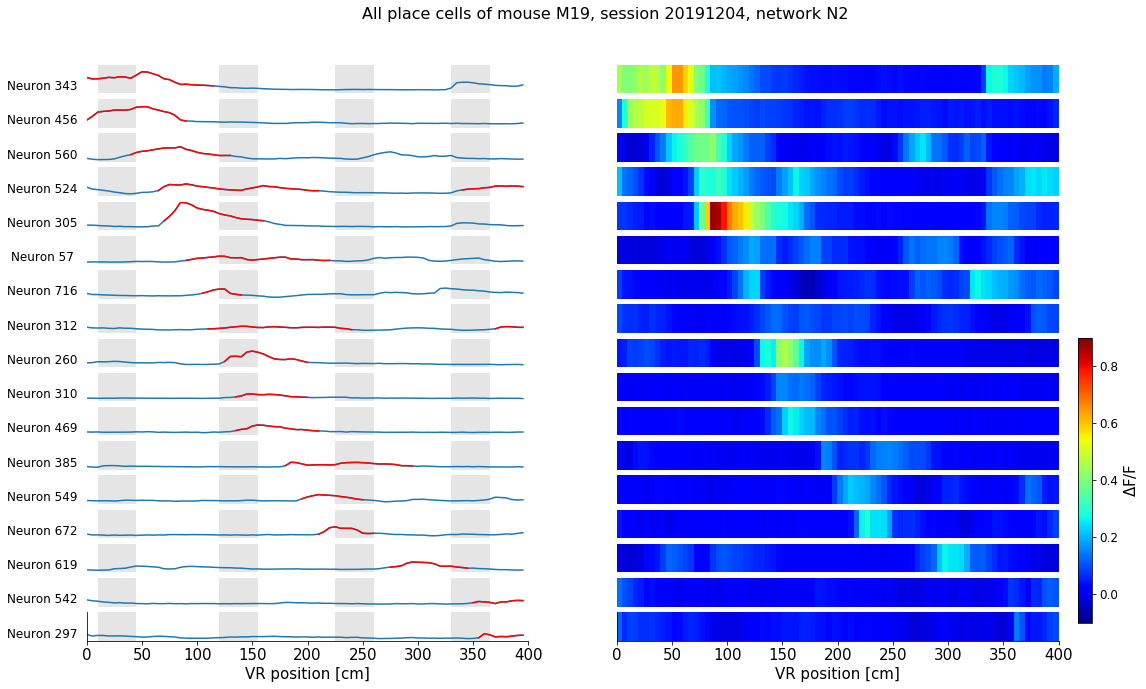

In [5]:
# Find place cells
pcf.params['trans_time'] = 0.2
pcf.find_place_cells()

# Plot place cells
pcf.plot_all_place_cells(save=False, show_neuron_id=True)

# # Save place cell plot
# %matplotlib qt
# pcf.plot_all_place_cells(save=True, show_neuron_id=True)
# %matplotlib inline

# # Save PCF object
# pcf.save(overwrite=False)

## Place cell quality check

To be sure that all place cells are actual place cells, it is wise to do a quality check afterwards.

This is first to check if all of the accepted place cells are actual cells and not background noise or duplicate cells. To filter these out, we can plot the contours of all place cells with the ``plot_pc_location()`` function.

In [7]:
%matplotlib qt
pcf.plot_pc_location(display_numbers=True, color='r')

Second, if we are sure that these components are true cells, we have to see if they are actually place cells. This should have been determined by the algorithm above, but it is better to check. To do this, we can plot the activity of all trials of a single neuron, not averaged. This way we can see ourselves how much the activity changes from trial to trial and if the classification as a place cell is justified (strong activity primarily at the same location in the corridor). This can be done with the ``plot_single_place_cell()`` function.

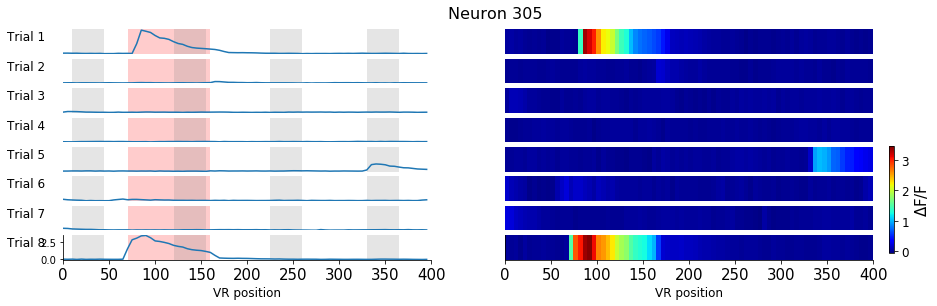

In [10]:
# go through all place cells and plot single trials by changing the input index
%matplotlib inline
pcf.plot_single_place_cell(3)

If you want to remove a place cell, you can add it to this list below and run the ``reject_place_cell()`` function once you are done (only run this function once because otherwise the indices will change and not be correct anymore!). 

This moves the corresponding place cells from the ``place_cells`` list into the ``place_cells_reject`` list inside the PCF function. The data will thus not be lost, but the cell will not be counted as a place cell anymore.

To ensure that only correct cells are removed, you have to provide the global neuron ID (title of single place cell plots) and not the internal index of the place_cells list.

In [ ]:
rejected_cells = [37, 39]

pcf.reject_place_cells(rejected_cells)

In [ ]:
pcf.params['bin_frame_count'] == 0

In [ ]:
pcf.params['n_bins']

Now we are done and can save the final PCF object one time.

In [ ]:
%matplotlib qt
pcf.plot_all_place_cells(save=True, show_neuron_id=True)
pcf.save(overwrite=True)

In [ ]:
plt.figure()
plt.plot(pcf.cnmf.estimates.C[31])

In [ ]:
%matplotlib qt
pcf.cnmf.estimates.plot_contours(img=pcf.cnmf.estimates.Cn, display_numbers=True)

In [ ]:
pcf.plot_individual_neuron(156, vr_aligned=True)